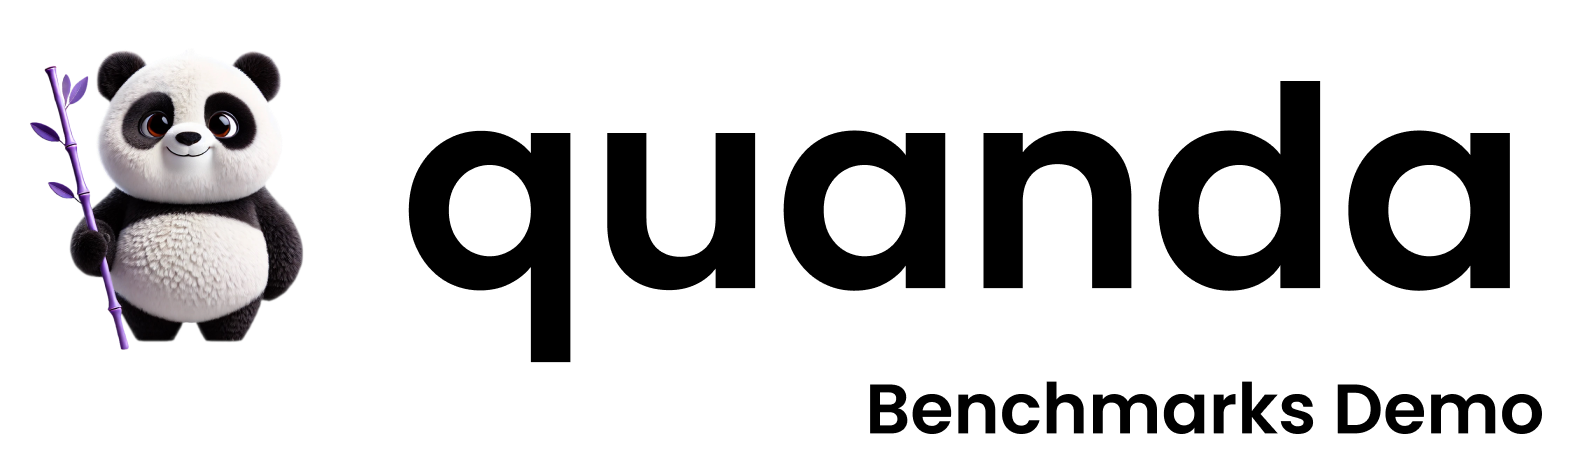

In this notebook, we will go through the different ways of creating an evaluation benchmark and comparing different attributors with it. First, we take the most straightforward route and go over the process of downloading a precomputed quanda benchmark for data attribution evaluation. This way, you can quickly write a quanda wrapper for your explainer and evaluate it against the existing explainers in the controlled setups we have prepared for you.

Afterwards, we will go through the steps of assembling a benchmark from existing components. This option allows you to create your own controlled setup, and use quanda benchmarks for evaluation of different data attributors.

Finally, we will summarize how to create your setup using quanda benchmarks, which includes managing datasets, training models and running evaluations.

Throughout this tutorial, we will be using a LeNet model trained on the MNIST dataset.

We first handle our include statements.

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(),".."))

import torch
import torchvision
from quanda.benchmarks.downstream_eval import ShortcutDetection, MislabelingDetection, SubclassDetection
from quanda.explainers.wrappers import (
    TRAK,
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCPFast,
    RepresenterPoints,
)



/home/yolcu/miniconda3/envs/quanda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision("medium")
to_img = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=0.0, std=2.),
    torchvision.transforms.Normalize(mean=-0.5, std=1.),
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),])

# Downloading Precomputed Benchmarks
In this part of the tutorial, we will use the Shortcut Detection metric.

We will use the benchmark corresponding to this metric to evaluate all data attributors currently included in quanda in terms of their ability to detect when the model is using a shortcut.

We will download the precomputed MNIST benchmark. This includes an MNIST dataset which has shortcut features (an 8-by-8 white box on a specific location) on a subset of its samples from the class 0, and a model trained on this dataset. This model has learned to classify images with these features to the class 0, and we will measure the extent to which this is reflected in the attributions of different methods.

In [3]:
cache_dir = str(os.path.join(os.getcwd(), "quanda_benchmark_tutorial_cache"))
device="cuda"
benchmark = ShortcutDetection.download(
    name="mnist_shortcut_detection",
    cache_dir=cache_dir,
    device=device,
)

/home/yolcu/Documents/Code/quanda/tutorials/../quanda/benchmarks/base.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(os.path.join(cache_dir, name + "

The benchmark object contains all information about the controlled evaluation setup. Let's see some samples with the shortcut features, using benchmark.feature_dataset and benchmark.shortcut_indices. 

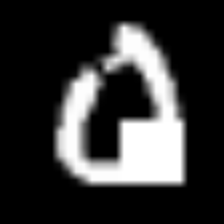

In [4]:
shortcut_img = benchmark.shortcut_dataset[benchmark.shortcut_indices[15]][0]
tensor_img=torch.concat([shortcut_img,shortcut_img,shortcut_img],dim=0)
img=to_img(tensor_img)
img

In [5]:
predictions = []
for i in benchmark.shortcut_indices:
    x,y = benchmark.shortcut_dataset[i]
    x=x.to(device)
    benchmark.model(x[None])
    predictions.append(benchmark.model(x[None]).argmax().item())
predictions=torch.tensor(predictions)
shortcut_rate=torch.mean((predictions==benchmark.shortcut_cls)*1.0)
shortcut_rate

tensor(0.9986)

## Prepare initialization parameters for TDA methods

We now prepare the initialization parameters of attributors: hyperparameters, and components from the benchmark as needed. Note that we do not provide the model and dataset to use for attribution, since those components will be supplied by the benchmark objects, while initializing the attributor during evaluation.

### Similarity Influence

In [6]:
captum_similarity_args = {
    "model_id": "mnist_shortcut_detection_tutorial",
    "layers": "model.fc_2",
    "cache_dir": os.path.join(cache_dir, "captum_similarity"),
}

### Arnoldi Influence Functions

Notice that the trained checkpoints have been saved to the `cache_dir` while downloading the benchmark. We can reach the paths of these checkpoints with `benchmark.checkpoint_paths`

In [7]:
hessian_num_samples=500 # number of samples to use for hessian estimation
hessian_ds=torch.utils.data.Subset(benchmark.shortcut_dataset, torch.randint(0, len(benchmark.shortcut_dataset), (hessian_num_samples,)))

captum_influence_args = {
        "checkpoint": benchmark.checkpoint_paths[-1],
        "layers": ["model.fc_3"],
        "batch_size": 8,
        "hessian_dataset": hessian_ds,
        "projection_dim": 5,
}

### TracInCP

In [8]:
captum_tracin_args = {
    "final_fc_layer": "model.fc_3",
    "loss_fn": torch.nn.CrossEntropyLoss(reduction="mean"),
    "checkpoints": benchmark.checkpoint_paths,
    "batch_size": 8,
}

### TRAK

In [9]:
trak_args = {
    "model_id": "mnist_shortcut_detection",
    "cache_dir": os.path.join(cache_dir, "trak"),
    "batch_size": 8,
    "proj_dim": 2048,
}

### Representer Points Selection

In [10]:
representer_points_args = {
    "model_id": "mnist_shortcut_detection",
    "cache_dir": os.path.join(cache_dir, "representer_points"),
    "batch_size": 8,
    "features_layer": "model.relu_4",
    "classifier_layer": "model.fc_3",
}

## Run the benchmark evaluation on the attributors
Note that some attributors take a long time to initialize or compute attributions. For a proof of concept, we recommend using `CaptumSimilarity` or `RepresenterPoints`, or lowering the parameter values given above (i.e. using low `proj_dim` for TRAK or a low Hessian dataset size for Arnoldi Influence)

In [11]:
attributors={
    # please comment out the explainers you are not interested in
    "captum_similarity": (CaptumSimilarity, captum_similarity_args),
    #"captum_arnoldi" : (CaptumArnoldi, captum_influence_args),
    #"captum_tracin" : (CaptumTracInCPFast, captum_tracin_args),
    #"trak" : (TRAK, trak_args),
    "representer" : (RepresenterPoints, representer_points_args),
}

In [12]:
results=dict()
for name, (cls, kwargs) in attributors.items():
    results[name] = benchmark.evaluate(
        explainer_cls=cls,
        expl_kwargs=kwargs,
        batch_size=8
    )["score"]

2024-09-30 18:34:08,998 - quanda.explainers.wrappers.captum_influence - INFO - Initializing Captum SimilarityInfluence explainer...
Metric evaluation, batch 1/16:   0%|          | 0/16 [00:00<?, ?it/s]/home/yolcu/miniconda3/envs/quanda/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/home/yolcu/Documents/Code/quanda/tutorials/../quanda/utils/common.py:233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the 

The `results` dictionary contains the results of the evaluation. The keys are the names of the explainers and the values are dictionaries containing the results.

In [ ]:
results

{'captum_similarity': 0.41747230291366577, 'representer': 0.4443182349205017}

# Assembling a benchmark from existing components

You may want to handle the creation of each component differently, using different datasets, architectures, training paradigms or a higher/lower percentage of manipulated samples. We now showcase how to create and use a quanda `Benchmark` object to use these components in the evaluation process.

To showcase different benchmarks, we will now switch to the `MislabelingDetection` benchmark. This benchmark evaluates the ability of data atttribution methods to identify mislabeled samples in the training dataset. This is done by training a model on a dataset which has a substantial amount of mislabeled samples. We then use the local data attribution methods to rank the training data. Original papers propose either using self-influence (i.e. the attribution of training samples on themselves) or some special methodology for each explainer (i.e. the global coefficients of the surrogate model in Representer Points). Quanda includes efficient implementation of self-influence or other strategies proposed in the original papers, whenever possible.

This ranking is then used to go through the dataset to check mislabelings. Quanda computes the cumulative mislabeling detection curve and returns the AUC score with respect to this curve.

Instead of creating the components from scratch, we will again download the benchmark and use collect the prepared components. We will then use the `MislabelingDetection.assemble` method to create the benchmark. Note that this is exactly what is happening when we are creating a benchmark using the `download` method.

In [ ]:
temp_benchmark = MislabelingDetection.download(
    name="mnist_mislabeling_detection",
    cache_dir=cache_dir,
    device=device,
)

## Required Components

In order to assemble a `MislabelingDetection` benchmark, we require the following components:
- A base training dataset with correct labels.
- A dictionary containing mislabeling information: integer keys are the indices of samples to change labels, and the values correspond to the new (wrong) labels that were used to train the model
- A model trained on the mislabeled dataset
- Number of classes in the dataset
- Dataset transform that was used during training, applied to samples before feeding them to the model. If the base dataset already includes the transform, then we can just set this to `None`, which is the case in this tutorial. If the base dataset serves raw samples, then the `dataset_transform` parameter allows the usage of a transform.

Let's collect these components from the downloaded benchmark. We then assemble the benchmark and evaluate the `RepresenterPoints` attributor with it. Note that the implementation depends on computing the self-influences of the whole training dataset. This procedure is fastest for the Representer Points attributor. Therefore, we use this explainer here.

In [ ]:
model=temp_benchmark.model
base_dataset=temp_benchmark.base_dataset
mislabeling_labels=temp_benchmark.mislabeling_labels
dataset_transform=None

## Assembling the benchmark and running the evaluation

In [ ]:
benchmark=MislabelingDetection.assemble(
    model=model,
    base_dataset=base_dataset,
    n_classes=10,
    mislabeling_labels=mislabeling_labels,
    dataset_transform=dataset_transform,
    device=device,
)
representer_points_args = {
    "model_id": "mnist_mislabeling_detection",
    "cache_dir": os.path.join(cache_dir, "representer_points"),
    "batch_size": 8,
    "features_layer": "model.relu_4",
    "classifier_layer": "model.fc_3",
}
benchmark.evaluate(
    explainer_cls=RepresenterPoints,
    expl_kwargs=representer_points_args,
)

2024-09-30 14:43:38,442 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...
2024-09-30 14:44:19,291 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...


{'score': 0.6750942468643188,
 'success_arr': tensor([False, False, False,  ..., False, False, False]),
 'curve': tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5907e-05, 5.5907e-05,
         5.5907e-05])}

# Generating a Benchmark from Scratch

We will now showcase how a benchmark can be created from only vanilla components. Quanda takes in all requires components and generates the benchmark, including dataset manipulations and model training, if applicable. Then the benchmark can be used to evaluate different attributors. This is done through the `Benchmark.generate` method.

We will go through this use-case with the `SubclassDetection` benchmark which groups classes of the base dataset into superclasses. A model is trained to predict these super classes, and the original labelhighest attributed datapoint for each test sample is observed. The benchmark expects this to be the same as the true class of the test sample. 

As such, we only need to provide these components to generate the benchmark:

- a model for the architecture
- a trainer: either a subclass instance of quanda's `BaseTrainer` or a Lightning `Trainer` object. If the trainer is a Lightning trainer, the `model` has to be a Lightning module. We will use a Lightning trainer with a Lightning module.
- a base dataset
- an evaluation dataset to be used as the test set for generating the attributions to evaluate
- a dataset transform. As in the case of `MislabelingDetection` explained above, the `dataset_transform` parameter can be `None` if the `base_dataset` and `eval_dataset` already include the required sample transformations. 
- the number of superclasses we want to generate the benchmark. 

Additionally, we can provide a dictionary which embodies a specific class grouping, or just use the default "random" value to randomly assign classes into superclasses, which is the approach we will take in this tutorial. Note that we will collect the base and evaluation datasets from the corresponding precomputed benchmark for simplicity and reproducibility. As such, these datasets will already include the transform required for sample normalization, which means we will supply `dataset_transform=None`.

Please note that calling `SubclassDetection.generate` will initiate model training, therefore it will potentially take a long time.

In [ ]:
from quanda.benchmarks.resources import pl_modules
import lightning as L

num_groups=2
model=pl_modules["MnistModel"](num_labels=num_groups, device=device)
trainer = L.Trainer(max_epochs=10)
dataset_transform = None

#Collect base and evaluation datasets from a precomputed benchmark for simplicity, instead of creating the dataset objects from scratch
base_dataset = temp_benchmark.base_dataset
eval_dataset = temp_benchmark.eval_dataset


benchmark=SubclassDetection.generate(
    model=model,
    trainer=trainer,
    base_dataset=base_dataset,
    eval_dataset=eval_dataset,
    dataset_transform=dataset_transform,
    n_classes=10,
    n_groups=num_groups,
    class_to_group="random"
)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yolcu/miniconda3/envs/quanda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
2024-09-30 15:35:38,928 - quanda.benchmarks.downstream_e

/home/yolcu/miniconda3/envs/quanda/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | LeNet5           | 43.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
43.7 K    Trainable params
0         Non-trainable params
43.7 K    Total params
0.175     Total estimated model params size (MB)
/home/yolcu/miniconda3/envs/quanda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 7500/7500 [01:50<00:00, 68.09it/s, v_num=6, train_loss_step=0.00018, train_loss_epoch=0.00628] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7500/7500 [01:50<00:00, 68.08it/s, v_num=6, train_loss_step=0.00018, train_loss_epoch=0.00628]


Now that we have trained the model on the MNIST dataset with randomly grouped classes, we finalize this tutorial by evaluating the `CaptumSimilarity` attributor:

In [ ]:
benchmark.evaluate(
    explainer_cls=CaptumSimilarity,
    expl_kwargs={
    "model_id": "mnist_subclass_detection_tutorial",
    "layers": "model.fc_2",
    "cache_dir": os.path.join(cache_dir, "captum_similarity"),
}
)

2024-09-30 16:33:37,689 - quanda.explainers.wrappers.captum_influence - INFO - Initializing Captum SimilarityInfluence explainer...
Metric evaluation, batch 16/16: 100%|██████████| 16/16 [20:25<00:00, 76.60s/it]


{'score': 0.14173227548599243}